In [1]:
# Import binfpy modules
import sequence
import webservice

# Import other modules
import pandas as pd
import random
import os
import subprocess
from collections import defaultdict
import matplotlib.pyplot as plt
import regex as re
from Bio import SearchIO
from IPython.display import Image, display

# Seqcurate code

In [2]:
def write_annot_from_fasta(*fasta_paths, drop_duplicates=True):
    
    seq_list = []
    duplicates = {}
    for fasta_path in fasta_paths:
        
        # Load FASTA file
        seqs = sequence.readFastaFile(fasta_path)
        
        # Add to annotation file
        for seq in seqs:
            if seq.name in duplicates:
                print (f'DUPLICATE:{seq.name} is in {duplicates[seq.name]} and {fasta_path}\n')
            else: 
                duplicates[seq.name] = fasta_path
            seq_list.append([seq.name, seq.info, seq.info.split(" ")[0], "".join(seq.sequence), fasta_path])
                
    df = pd.DataFrame(seq_list, columns=['Name', 'Info', 'Truncated Info', 'Sequence', 'Original FASTA'])
    
    if drop_duplicates:
        df = df.drop_duplicates(subset='Name', keep='first')
    df.set_index('Name')
    
    return df


def annotate_col_from_dict(df, col, annot_dict, match='Name'):
    df.loc[df[match].isin(annot_dict.keys()), col] = df[match].map(annot_dict)
    
    return df

def add_col_from_up_dict(df, cols_to_add, up_dict):
    
    for col in cols_to_add:
        if not col in df:
            df[col] = ""

    for name,annots in up_dict.items():
        
        for key in annots.keys():
            df.loc[df['Name'].str.contains(name), key] = annots.get(key)
            
    return df


def annotate_col_from_other_df(df, other_df, col, match_from='Name', match_to='Name'):
    
    other_dict = dict(zip(other_df[match_from], other_df[col]))
        
    df = annotate_col_from_dict(df, col, other_dict, match_to)
    
    return df


def get_subset(df, *cols_dict, include=True):
    for col_dict in cols_dict:
        if type(col_dict) != dict:
            raise TypeError('col_dict must be a dictionary')
        for col, vals in col_dict.items():
            if vals == '*': # Get all the entries with values that exist
                
                if include:
                    df = df[~df[col].isna()]
                else:
                    df = df[df[col].isna()]
            else: # Get all the entries with the specified values
                if include:
                    df = df[df[col].isin(vals)]
                else:
                    df[~df[col].isin(vals)] 

    return df


def write_to_fasta(df, outpath):
    seq_list = [sequence.Sequence(sequence=r.Sequence, name=r.Info) for r in df.itertuples()]
    sequence.writeFastaFile(outpath, seq_list)

def randstring(length=10):
    valid_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    return ''.join((random.choice(valid_letters) for i in range(length)))

# Load the FASTA files and create an annotation file

In [14]:
seq_path = "./<seqpath>.fasta"
aln_path = "./<alnname>.aln"
tree_path = "./<treename>.nwk"

seq_path = "./test.fasta"
aln_path = "./test.aln"
tree_path = "./test.nwk"



annotations = write_annot_from_fasta(seq_path)
seqs = sequence.readFastaFile(seq_path)

annotations.head(5)

,Name,Info,Truncated Info,Sequence,Original FASTA
0,A8NE23,sp|A8NE23|COP3_COPC7__Cop3__Mischko Alpha-muur...,sp|A8NE23|COP3_COPC7__Cop3__Mischko,ELTGYCYPYTTPERLRVVADFLNYLFHLDNISDGMMTRETAVLADV...,./test.fasta
1,B2J4A4,sp|B2J4A4|GERAS_NOSP7 Germacrene A synthase OS...,sp|B2J4A4|GERAS_NOSP7,MNQLLCPGLYCPFPSQTNKYVDVLEEYSLEWVLRFNLLANESAYKR...,./test.fasta
2,__Omp1__Mischko,__Omp1__Mischko,__Omp1__Mischko,MKYTSFALPDLASSCDYNLRFNKYHRSVSPETKKWFFRLSPASQAD...,./test.fasta
3,A8NU13,sp|A8NU13|COP4_COPC7__Cop4__Mischko Linoleate ...,sp|A8NU13|COP4_COPC7__Cop4__Mischko,MRPTARQFTLPDLFSICPLQDATNPWYKQAAAESRAWINSYNIFTD...,./test.fasta
4,B5H7H3,sp|B5H7H3|PRISS_STRE2 Pristinol synthase OS=St...,sp|B5H7H3|PRISS_STRE2,MAHETTSGRRLPDPTSPSDPTRRTAAIRIPFPARLNPHAERARQHT...,./test.fasta


# Add the information from UniProt

In [15]:
names = [seq.name for seq in seqs]

cols = ['entry name',
'genes',
'genes(PREFERRED)',
'genes(ALTERNATIVE)',
'genes(OLN)',
'genes(ORF)',
'organism',
'organism-id',
'protein names',
'proteome',
'lineage(ALL)',
'virus hosts',
'fragment',
'encodedon',
'comment(ALTERNATIVE PRODUCTS)',
'comment(ERRONEOUS GENE MODEL PREDICTION)',
'comment(ERRONEOUS INITIATION)',
'comment(ERRONEOUS TERMINATION)',
'comment(ERRONEOUS TRANSLATION)',
'comment(FRAMESHIFT)',
'comment(MASS SPECTROMETRY)',
'comment(POLYMORPHISM)',
'comment(RNA EDITING)',
'comment(SEQUENCE CAUTION)',
'length',
'mass',
'feature(ALTERNATIVE SEQUENCE)',
'feature(NATURAL VARIANT)',
'feature(NON ADJACENT RESIDUES)',
'feature(NON STANDARD RESIDUE)',
'feature(NON TERMINAL RESIDUE)',
'feature(SEQUENCE CONFLICT)',
'feature(SEQUENCE UNCERTAINTY)',
'version(sequence)',
'ec',
'comment(ABSORPTION)',
'comment(CATALYTIC ACTIVITY)',
'chebi',
'chebi(Catalytic activity)',
'chebi(Cofactor)',
'chebi-id',
'comment(COFACTOR)',
'comment(ENZYME REGULATION)',
'comment(FUNCTION)',
'comment(KINETICS)',
'comment(PATHWAY)',
'comment(REDOX POTENTIAL)',
'comment(TEMPERATURE DEPENDENCE)',
'comment(PH DEPENDENCE)',
'feature(ACTIVE SITE)',
'feature(BINDING SITE)',
'feature(DNA BINDING)',
'feature(METAL BINDING)',
'feature(NP BIND)',
'feature(SITE)',
'annotation score',
'features',
'comment(CAUTION)',
'comment(MISCELLANEOUS)',
'keywords',
'context',
'existence',
'tools',
'reviewed',
'comment(SUBUNIT)',
'interactor',
'comment(DEVELOPMENTAL STAGE)',
'comment(INDUCTION)',
'comment(TISSUE SPECIFICITY)',
'go',
'go(biological process)',
'go(molecular function)',
'go(cellular component)',
'go-id',
'comment(ALLERGEN)',
'comment(BIOTECHNOLOGY)',
'comment(DISRUPTION PHENOTYPE)',
'comment(DISEASE)',
'comment(PHARMACEUTICAL)',
'comment(TOXIC DOSE)',
'comment(SUBCELLULAR LOCATION)',
'feature(INTRAMEMBRANE)',
'feature(TOPOLOGICAL DOMAIN)',
'feature(TRANSMEMBRANE)',
'comment(PTM)',
'feature(CHAIN)',
'feature(CROSS LINK)',
'feature(DISULFIDE BOND)',
'feature(GLYCOSYLATION)',
'feature(INITIATOR METHIONINE)',
'feature(LIPIDATION)',
'feature(MODIFIED RESIDUE)',
'feature(PEPTIDE)',
'feature(PROPEPTIDE)',
'feature(SIGNAL)',
'feature(TRANSIT)',
'3d',
'feature(BETA STRAND)',
'feature(HELIX)',
'feature(TURN)',
'citationmapping',
'citation',
'created',
'last-modified',
'sequence-modified',
'version(entry)',
'comment(DOMAIN)',
'comment(SIMILARITY)',
'families',
'feature(COILED COIL)',
'feature(COMPOSITIONAL BIAS)',
'feature(DOMAIN EXTENT)',
'feature(MOTIF)',
'feature(REGION)',
'feature(REPEAT)',
'feature(ZINC FINGER)',
'lineage(all)',
'lineage(SUPERKINGDOM)',
'lineage(KINGDOM)',
'lineage(PHYLUM)',
'lineage(CLASS)',
'lineage(ORDER)',
'lineage(FAMILY)',
'lineage(GENUS)',
'lineage(SPECIES)']

up_dict = webservice.getUniProtDict(names, cols)

annotations = add_col_from_up_dict(annotations, cols, up_dict)

P0DL13	PRO1_ARMGA	PRO1 ARMGADRAFT_1000221	PRO1			ARMGADRAFT_1000221	Armillaria gallica (Bulbous honey fungus) (Armillaria bulbosa)	47427	Delta(6)-protoilludene synthase (EC 4.2.3.135) (Melleolides biosynthesis cluster protein PRO1)	UP000217790: Unassembled WGS sequence	cellular organisms, Eukaryota, Opisthokonta, Fungi, Dikarya, Basidiomycota, Agaricomycotina, Agaricomycetes, Agaricomycetidae, Agaricales, Physalacriaceae, Armillaria, Armillaria gallica (Bulbous honey fungus) (Armillaria bulbosa)														345	39,793		VARIANT 90;  /note="A -> S (in strain: FU02472)"; VARIANT 210;  /note="N -> K (in strain: FU02472)"; VARIANT 343;  /note="S -> F (in strain: FU02472)"						2	4.2.3.135		CATALYTIC ACTIVITY: Reaction=(2E,6E)-farnesyl diphosphate = Delta(6)-protoilludene + diphosphate; Xref=Rhea:RHEA:34695, ChEBI:CHEBI:33019, ChEBI:CHEBI:68655, ChEBI:CHEBI:175763; EC=4.2.3.135; Evidence={ECO:0000269|PubMed:21148562};	(2E,6E)-farnesyl diphosphate [CHEBI:175763]; Mg(2+) [CHEBI:18420]; diphos


feature(PROPEPTIDE)
94
124

feature(SIGNAL)
95
124

feature(TRANSIT)
96
124

3d
97
124

feature(BETA STRAND)
98
124

feature(HELIX)
99
124

feature(TURN)
100
124
27403888
citationmapping
101
124
2018-02-28
citation
102
124
2020-10-07
created
103
124
2008-10-14
last-modified
104
124
44
sequence-modified
105
124
DOMAIN: The Asp-Asp-Xaa-Xaa-Asp (DDXXD) motif is important for the catalytic activity, presumably through binding to Mg(2+). {ECO:0000305|PubMed:27403888}.
version(entry)
106
124
SIMILARITY: Belongs to the terpene synthase family. {ECO:0000305}.
comment(DOMAIN)
107
124
Terpene synthase family
comment(SIMILARITY)
108
124

families
109
124

feature(COILED COIL)
110
124

feature(COMPOSITIONAL BIAS)
111
124
MOTIF 100..104;  /note="DDXXD motif";  /evidence="ECO:0000305|PubMed:27403888"
feature(DOMAIN EXTENT)
112
124
REGION 337..338;  /note="Substrate binding";  /evidence="ECO:0000250|UniProtKB:B5HDJ6"
feature(MOTIF)
113
124

feature(REGION)
114
124

feature(REPEAT)
115
124
cellular o

38
124
(2E,6E)-farnesyl diphosphate [CHEBI:175763]; Mg(2+) [CHEBI:18420]; (-)-beta-caryophyllene [CHEBI:10357]; diphosphate [CHEBI:33019]
chebi(Catalytic activity)
39
124
(2E,6E)-farnesyl diphosphate [CHEBI:175763]; (-)-beta-caryophyllene [CHEBI:10357]; diphosphate [CHEBI:33019]
chebi(Cofactor)
40
124
Mg(2+) [CHEBI:18420]
chebi-id
41
124
CHEBI:175763; CHEBI:18420; CHEBI:10357; CHEBI:33019
comment(COFACTOR)
42
124
COFACTOR: Name=Mg(2+); Xref=ChEBI:CHEBI:18420; Evidence={ECO:0000250|UniProtKB:B5HDJ6};  Note=Binds 3 Mg(2+) ions per subunit. {ECO:0000250|UniProtKB:B5HDJ6};
comment(ENZYME REGULATION)
43
124

comment(FUNCTION)
44
124
FUNCTION: Catalyzes the conversion of (2E,6E)-farnesyl diphosphate (FPP) to yield the bicyclic sesquiterpene (2S,10R)-(-)-(E)-beta-caryophyllene via a probable 1,10-cyclization, which could involve the abstraction of the pyrophosphate from FPP to yield a (E,E)-germacradienyl cation. {ECO:0000269|PubMed:27829890}.
comment(KINETICS)
45
124

comment(PATHWAY)
46
124

124
Reference proteome
context
61
124
Predicted
existence
62
124
unreviewed
tools
63
124

reviewed
64
124

comment(SUBUNIT)
65
124

interactor
66
124

comment(DEVELOPMENTAL STAGE)
67
124

comment(INDUCTION)
68
124

comment(TISSUE SPECIFICITY)
69
124

go
70
124

go(biological process)
71
124

go(molecular function)
72
124

go(cellular component)
73
124

go-id
74
124

comment(ALLERGEN)
75
124

comment(BIOTECHNOLOGY)
76
124

comment(DISRUPTION PHENOTYPE)
77
124

comment(DISEASE)
78
124

comment(PHARMACEUTICAL)
79
124

comment(TOXIC DOSE)
80
124

comment(SUBCELLULAR LOCATION)
81
124

feature(INTRAMEMBRANE)
82
124

feature(TOPOLOGICAL DOMAIN)
83
124

feature(TRANSMEMBRANE)
84
124

comment(PTM)
85
124

feature(CHAIN)
86
124

feature(CROSS LINK)
87
124

feature(DISULFIDE BOND)
88
124

feature(GLYCOSYLATION)
89
124

feature(INITIATOR METHIONINE)
90
124

feature(LIPIDATION)
91
124

feature(MODIFIED RESIDUE)
92
124

feature(PEPTIDE)
93
124

feature(PROPEPTIDE)
94
124

feature(SIGNAL)
95
124

fea

genes
2
124
CONPUDRAFT_63003
genes(PREFERRED)
3
124

genes(ALTERNATIVE)
4
124

genes(OLN)
5
124

genes(ORF)
6
124
CONPUDRAFT_63003
organism
7
124
Coniophora puteana (strain RWD-64-598) (Brown rot fungus)
organism-id
8
124
741705
protein names
9
124
Terpene cyclase (EC 4.2.3.-)
proteome
10
124
UP000053558: Unassembled WGS sequence
lineage(ALL)
11
124
cellular organisms, Eukaryota, Opisthokonta, Fungi, Dikarya, Basidiomycota, Agaricomycotina, Agaricomycetes, Agaricomycetidae, Boletales, Coniophorineae, Coniophoraceae, Coniophora, Coniophora puteana, Coniophora puteana (strain RWD-64-598) (Brown rot fungus)
virus hosts
12
124

fragment
13
124

encodedon
14
124

comment(ALTERNATIVE PRODUCTS)
15
124

comment(ERRONEOUS GENE MODEL PREDICTION)
16
124

comment(ERRONEOUS INITIATION)
17
124

comment(ERRONEOUS TERMINATION)
18
124

comment(ERRONEOUS TRANSLATION)
19
124

comment(FRAMESHIFT)
20
124

comment(MASS SPECTROMETRY)
21
124

comment(POLYMORPHISM)
22
124

comment(RNA EDITING)
23
124

comment(

chebi(Catalytic activity)
39
124

chebi(Cofactor)
40
124
Mg(2+) [CHEBI:18420]
chebi-id
41
124
CHEBI:18420
comment(COFACTOR)
42
124
COFACTOR: Name=Mg(2+); Xref=ChEBI:CHEBI:18420; Evidence={ECO:0000256|ARBA:ARBA00001946, ECO:0000256|RuleBase:RU366034}; 
comment(ENZYME REGULATION)
43
124

comment(FUNCTION)
44
124

comment(KINETICS)
45
124

comment(PATHWAY)
46
124

comment(REDOX POTENTIAL)
47
124

comment(TEMPERATURE DEPENDENCE)
48
124

comment(PH DEPENDENCE)
49
124

feature(ACTIVE SITE)
50
124

feature(BINDING SITE)
51
124

feature(DNA BINDING)
52
124

feature(METAL BINDING)
53
124

feature(NP BIND)
54
124

feature(SITE)
55
124

annotation score
56
124
1 out of 5
features
57
124

comment(CAUTION)
58
124
CAUTION: The sequence shown here is derived from an EMBL/GenBank/DDBJ whole genome shotgun (WGS) entry which is preliminary data. {ECO:0000313|EMBL:EIW83595.1}.
comment(MISCELLANEOUS)
59
124

keywords
60
124
Lyase;Magnesium;Metal-binding;Reference proteome
context
61
124
Inferred from homo

124

comment(ALLERGEN)
75
124

comment(BIOTECHNOLOGY)
76
124

comment(DISRUPTION PHENOTYPE)
77
124

comment(DISEASE)
78
124

comment(PHARMACEUTICAL)
79
124

comment(TOXIC DOSE)
80
124

comment(SUBCELLULAR LOCATION)
81
124

feature(INTRAMEMBRANE)
82
124

feature(TOPOLOGICAL DOMAIN)
83
124

feature(TRANSMEMBRANE)
84
124

comment(PTM)
85
124

feature(CHAIN)
86
124

feature(CROSS LINK)
87
124

feature(DISULFIDE BOND)
88
124

feature(GLYCOSYLATION)
89
124

feature(INITIATOR METHIONINE)
90
124

feature(LIPIDATION)
91
124

feature(MODIFIED RESIDUE)
92
124

feature(PEPTIDE)
93
124

feature(PROPEPTIDE)
94
124

feature(SIGNAL)
95
124

feature(TRANSIT)
96
124

3d
97
124

feature(BETA STRAND)
98
124

feature(HELIX)
99
124

feature(TURN)
100
124
22745431
citationmapping
101
124
2020-02-26
citation
102
124
2020-10-07
created
103
124
2020-02-26
last-modified
104
124
5
sequence-modified
105
124

version(entry)
106
124
SIMILARITY: Belongs to the terpene synthase family. {ECO:0000256|ARBA:ARBA00006333, 

feature(CROSS LINK)
87
124

feature(DISULFIDE BOND)
88
124

feature(GLYCOSYLATION)
89
124

feature(INITIATOR METHIONINE)
90
124

feature(LIPIDATION)
91
124

feature(MODIFIED RESIDUE)
92
124

feature(PEPTIDE)
93
124

feature(PROPEPTIDE)
94
124

feature(SIGNAL)
95
124

feature(TRANSIT)
96
124

3d
97
124

feature(BETA STRAND)
98
124

feature(HELIX)
99
124

feature(TURN)
100
124
22745431
citationmapping
101
124
2020-02-26
citation
102
124
2020-08-12
created
103
124
2020-02-26
last-modified
104
124
4
sequence-modified
105
124

version(entry)
106
124
SIMILARITY: Belongs to the terpene synthase family. {ECO:0000256|ARBA:ARBA00006333, ECO:0000256|RuleBase:RU366034}.
comment(DOMAIN)
107
124
Terpene synthase family
comment(SIMILARITY)
108
124

families
109
124

feature(COILED COIL)
110
124

feature(COMPOSITIONAL BIAS)
111
124

feature(DOMAIN EXTENT)
112
124

feature(MOTIF)
113
124

feature(REGION)
114
124

feature(REPEAT)
115
124
cellular organisms, Eukaryota, Opisthokonta, Fungi, Dikarya, Basid

22745431
citationmapping
101
124
2020-02-26
citation
102
124
2020-08-12
created
103
124
2020-02-26
last-modified
104
124
3
sequence-modified
105
124

version(entry)
106
124

comment(DOMAIN)
107
124

comment(SIMILARITY)
108
124

families
109
124

feature(COILED COIL)
110
124

feature(COMPOSITIONAL BIAS)
111
124

feature(DOMAIN EXTENT)
112
124

feature(MOTIF)
113
124

feature(REGION)
114
124

feature(REPEAT)
115
124
cellular organisms, Eukaryota, Opisthokonta, Fungi, Dikarya, Basidiomycota, Agaricomycotina, Agaricomycetes, Agaricomycetidae, Boletales, Coniophorineae, Coniophoraceae, Coniophora, Coniophora puteana, Coniophora puteana (strain RWD-64-598) (Brown rot fungus)
feature(ZINC FINGER)
116
124
Eukaryota
lineage(all)
117
124
Fungi
lineage(SUPERKINGDOM)
118
124
Basidiomycota
lineage(KINGDOM)
119
124
Agaricomycetes
lineage(PHYLUM)
120
124
Boletales
lineage(CLASS)
121
124
Coniophoraceae
lineage(ORDER)
122
124
Coniophora
lineage(FAMILY)
123
124
Coniophora puteana
A0A5M3MEB5	A0A5M3MEB5_C

124

interactor
66
124

comment(DEVELOPMENTAL STAGE)
67
124

comment(INDUCTION)
68
124
lyase activity [GO:0016829]; metal ion binding [GO:0046872]
comment(TISSUE SPECIFICITY)
69
124

go
70
124
lyase activity [GO:0016829]; metal ion binding [GO:0046872]
go(biological process)
71
124

go(molecular function)
72
124
GO:0016829; GO:0046872
go(cellular component)
73
124

go-id
74
124

comment(ALLERGEN)
75
124

comment(BIOTECHNOLOGY)
76
124

comment(DISRUPTION PHENOTYPE)
77
124

comment(DISEASE)
78
124

comment(PHARMACEUTICAL)
79
124

comment(TOXIC DOSE)
80
124

comment(SUBCELLULAR LOCATION)
81
124

feature(INTRAMEMBRANE)
82
124

feature(TOPOLOGICAL DOMAIN)
83
124

feature(TRANSMEMBRANE)
84
124

comment(PTM)
85
124

feature(CHAIN)
86
124

feature(CROSS LINK)
87
124

feature(DISULFIDE BOND)
88
124

feature(GLYCOSYLATION)
89
124

feature(INITIATOR METHIONINE)
90
124

feature(LIPIDATION)
91
124

feature(MODIFIED RESIDUE)
92
124

feature(PEPTIDE)
93
124

feature(PROPEPTIDE)
94
124

feature(SIGNAL

# Save the annotation file

In [16]:
df = annotations
df.to_csv("./annotations.csv", index=False)

Make image based on entry name
Warnning: [39] terminal nodes could not be found in the alignment.

Running tree_annot
{'sp|A8NE23|COP3_COPC7__Cop3__Mischko': 'COP3_COPC7', 'sp|B2J4A4|GERAS_NOSP7': 'GERAS_NOSP7', '__Omp1__Mischko': None, 'sp|A8NU13|COP4_COPC7__Cop4__Mischko': 'COP4_COPC7', 'sp|B5H7H3|PRISS_STRE2': 'PRISS_STRE2', '__Omp10__Mischko': None, 'tr|A8NUX6|A8NUX6_COPC7__Cop2__Mischko': 'A8NUX6_COPC7', 'sp|K0K750|BCAS_SACES': 'BCAS_SACES', '__Omp3__Mischko': None, 'sp|P0DL13|PRO1_ARMGA': 'PRO1_ARMGA', '__Omp4__Mischko': None, 'tr|A0A5M3M7M3|A0A5M3M7M3_CONPW__Copu22__Mischko': 'A0A5M3M7M3_CONPW', '__Omp5a__Mischko': None, 'tr|A0A5M3MEB5|A0A5M3MEB5_CONPW__Copu24__Mischko': 'A0A5M3MEB5_CONPW', '__Omp5b__Mischko': None, 'tr|A0A5M3MWR3|A0A5M3MWR3_CONPW__Copu23__Mischko': 'A0A5M3MWR3_CONPW', '__Omp6__Mischko': None, 'sp|A8NCK5|COP6_COPC7__Cop6__Mischko': 'COP6_COPC7', '__Omp7__Mischko': None, 'tr|S8FSY2|S8FSY2_FOMPI__Fompi1|84944__Mischko': 'S8FSY2_FOMPI', '__GME9210__Mischko': None, 

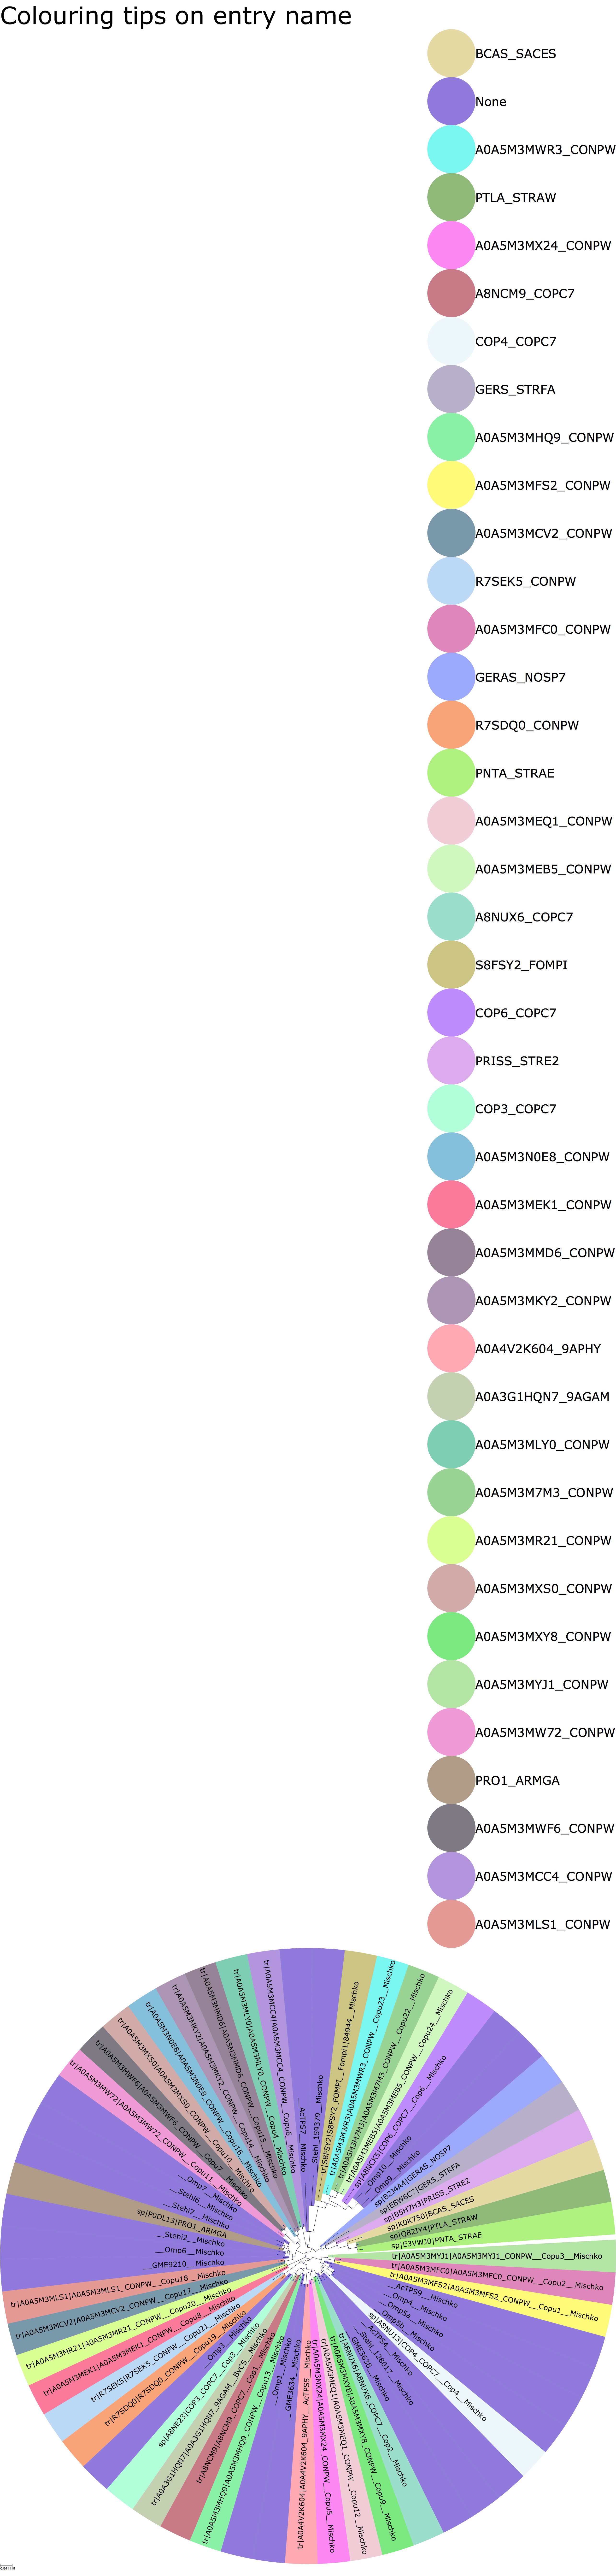

In [17]:
annot_path = "./annotations.csv"

annotations = pd.read_csv(annot_path)

image_names = []

proc_name = 'kari_annotations'

rand_str = randstring(4) 

# Use tree_annot to visualise all possible taxonomic ranks
for annot_col in cols:
    print (f'Make image based on {annot_col}')
    img_path = f"./{proc_name}_{rand_str}_{annot_col}.png"
    output = subprocess.getoutput(f'python3 ./tree_annot.py -t {tree_path} -a {aln_path} -c {annot_path} --col "{annot_col}" --match_from "Truncated Info" -r 4425 -o "{img_path}"')
    print (output)


    image_names.append(img_path)
    break


print (image_names)
# Comment this out if you don't want to show images in notebook
for image_name in image_names:
    display(Image(filename=image_name, width = 400, height = 200))